In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant IV.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant V.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant I.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant III.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant II.csv


# Loading the Base file

In [2]:
df = pd.read_csv("/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv")

# PREREQUISITES 

In [3]:
import sklearn
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,MinMaxScaler,OneHotEncoder 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold , cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, recall_score , confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE


import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2024-07-17 06:31:29.486159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 06:31:29.486280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 06:31:29.620321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Checking null values in a column on the bases of Data Card and removing the columns

In [4]:
val = df.groupby(['fraud_bool','prev_address_months_count'])['income'].count().reset_index()
val[(val['fraud_bool']== 0) &  (val['prev_address_months_count'] == -1) ]['income']
#prev_address_months_count is not a reliable coulumn because  approx 72 percent data is missing in it

#velocity_6h/velocity_24h will not use this column because it gives data for last 6 hours and we are going with more reliable field because the values of 
#these of these fields can vary according to days

0    702786
Name: income, dtype: int64

# Making values 0 where the values are between 0 and x value but -values are in data

In [5]:
#df['bank_months_count'].value_counts()
#approx 2 lakh records are missing we need to change it to zero
df['bank_months_count'] = np.where(df.bank_months_count < 0 , 0,df.bank_months_count)

In [6]:
#df['proposed_credit_limit'].value_counts()
#41 values are 2100 but according to datacard value is between 200, 2000
df['proposed_credit_limit'] = np.where(df.proposed_credit_limit > 2000 , 2000,df.proposed_credit_limit )

# Dividing the data in train and test

In [7]:
X = df.loc[:, df.columns != 'fraud_bool']
Y = df.loc[:, df.columns == 'fraud_bool']

In [8]:
COL = X.columns

In [9]:
#X['prev_address_months_count'] = np.where(X.prev_address_months_count < 0 , 0,X.prev_address_months_count )
#X['current_address_months_count'] = np.where(X.current_address_months_count < 0, 0,X.current_address_months_count )
#X['days_since_request'] = np.where(X.days_since_request < 0, 0,X.days_since_request )
#X['zip_count_4w'] = np.where(X.zip_count_4w < 0, 0,X.zip_count_4w )
#X['bank_branch_count_8w'] = np.where(X.bank_branch_count_8w < 0, 0,X.bank_branch_count_8w )
#X['bank_months_count'] = np.where(X.bank_months_count < 0, 0,X.bank_months_count )


In [10]:
#ct = ColumnTransformer([
    #('os',OrdinalEncoder(),[7,14,17,24,26]),
    #('mm',MinMaxScaler(),[2,3,5,8,20]),
    #('st',StandardScaler(),[15])
#],remainder='passthrough')

In [11]:
#X= ct.fit_transform(X)

# Feature Transformation of data

In [12]:
colum = X.select_dtypes(include=['object'])

In [13]:
ohe = OneHotEncoder(handle_unknown="ignore")

obj = pd.DataFrame(ohe.fit_transform(colum).toarray())

In [14]:
minmx = ['prev_address_months_count','current_address_months_count','days_since_request','zip_count_4w','bank_months_count']
mm = MinMaxScaler()
mim = X[minmx]

MIN = pd.DataFrame(mm.fit_transform(mim),columns=minmx)

In [15]:
c =[]
a = X.columns
b = X.select_dtypes(include=['object'])

for i in a:
    if i not in b and i not in minmx :
        c.append(i)

In [16]:
X = X.loc[: ,c ]

In [17]:
st=StandardScaler()
X = pd.DataFrame(st.fit_transform(X),columns=c)

In [18]:
X = pd.concat([X,MIN], axis=1)

# Checking the correlation between features and removing higly correlated feature

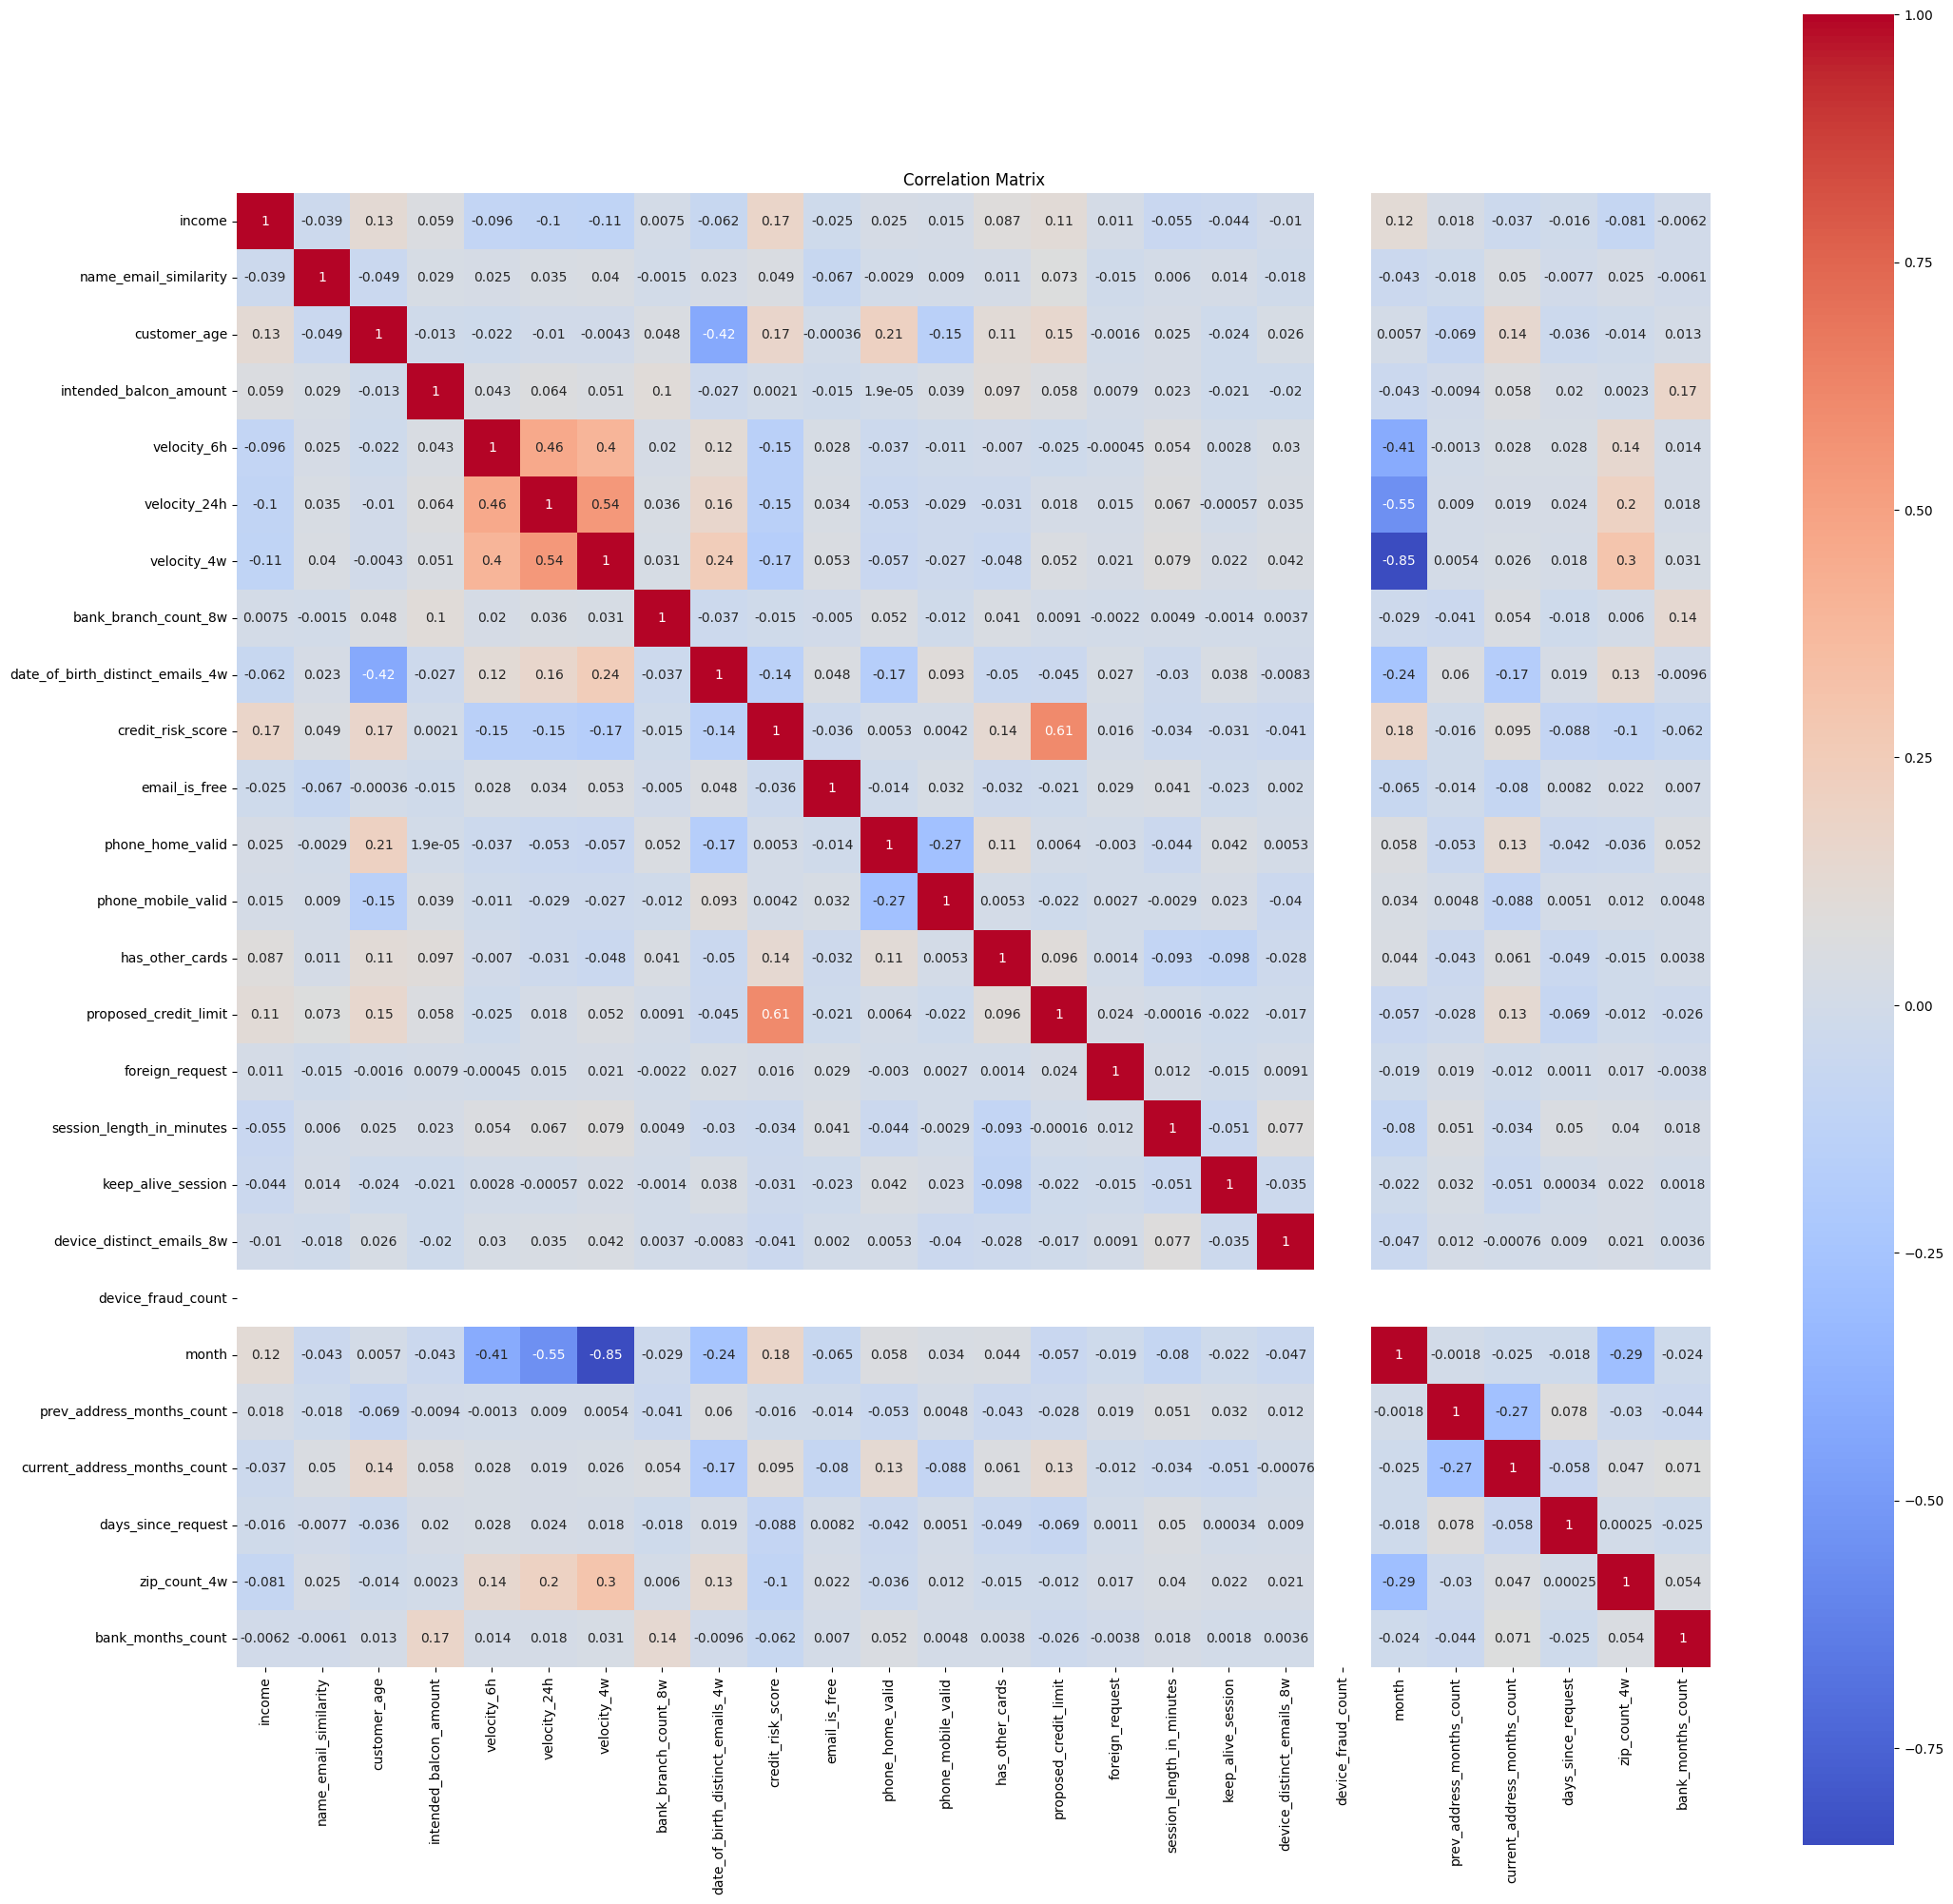

In [19]:
corr_matrix = X.corr()

# Create a heatmap to visualize the correlation matrix

plt.figure(figsize=(25, 25))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Matrix')

plt.show()

In [20]:
#These are highly correlated features in the data, we have choosen the correlation greater then 0.3

#velocity_6h
#velocity_24h
#velocity_4w
#proposed_credit_limit
#credit_risk_limit

high_cor = ['velocity_6h','velocity_24h','velocity_4w','proposed_credit_limit','credit_risk_limit','month','customer_age',
            'date_of_birth_distinct_emails_4w']



#high_cor =[]
#thresh =  0.3
#for i in corr_matrix:
   # for j in corr_matrix:
       # val = abs(corr_matrix[i][j])
        #print(val)
        #if val > thresh and val != 1:
            #print(val)
          #  high_cor.append(i) 
            
       

In [21]:
#high_cor = list(set(high_cor)) 
#high_cor

# Checking the variance of different fetaures and doing features selection baased on it

In [22]:
var = X.var()
var = pd.DataFrame(var).reset_index()
var = var[var[0] >= 0.02]
var_col = var['index'].tolist()

In [23]:
fi = []
var_col

for i in var_col:
    if i not in high_cor:
        fi.append(i)

In [24]:
X = X.loc[: ,fi]

# Outlier value updating

In [25]:
for i in fi:

    x_mean = X[i].mean()
    x_std = X[i].std()

    std_3 = 3 * x_std
    std_3ned  = -3 * x_std
    
    X[i]= np.where((((X[i] - x_mean) / x_std) < std_3ned )  ==True ,std_3ned,X[i])
    
    X[i]= np.where(( ((X[i] - x_mean) / x_std) > std_3 )  ==True ,std_3,X[i])

In [26]:
X = pd.concat([X,obj], axis=1)
X.columns = X.columns.astype(str)

# Doing Train test split

In [27]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.8,random_state=20)

# Sampling technique applying

In [28]:
#sm = SMOTE(random_state=40)
#x_resam , y_resam = sm.fit_resample(x_train,y_train)

rus = RandomUnderSampler(random_state=42, replacement=False)
x_resam , y_resam = rus.fit_resample(x_train,y_train)

In [29]:
y_train.value_counts()

fraud_bool
0             791215
1               8785
Name: count, dtype: int64

In [30]:
y_test.value_counts()

fraud_bool
0             197756
1               2244
Name: count, dtype: int64

In [31]:
y_resam = np.array(y_resam).reshape(-1,)
y_test = np.array(y_test).reshape(-1,)

# Setting the algorithms

In [32]:
lr = LogisticRegression(solver='sag', max_iter=1000)

lrf_new = LogisticRegression(C= 0.4,
 class_weight = 'balanced',
 max_iter = 1000,
 penalty =  'l1',
 random_state = 60,
 solver = 'liblinear')

rf = RandomForestClassifier(n_estimators=20)

rfn = RandomForestClassifier(n_estimators=30, min_samples_split=4,
                              min_impurity_decrease=0.01, bootstrap=True, oob_score=True, 
                             random_state=20)
gnb = GaussianNB()

bg = BaggingClassifier(estimator=lrf_new, n_estimators=50, 
                       bootstrap=True, bootstrap_features=True)

estimator = [('lr',lr), ('rfn',rfn),('gnb',gnb),('bg',bg)]

vc = VotingClassifier(estimators=estimator,weights = [2,0.5,0.7,0.7])


# Applying random forest classifier for feature selection

In [33]:
rf.fit(x_resam,y_resam)
rf_pred = rf.predict(x_test)
print(f1_score(y_test,rf_pred))

feature = rf.feature_importances_
col = x_train.columns

dic = { "fea": feature , "column" : col}

feat = pd.DataFrame(dic)

feat = feat[feat['fea'] > 0.0002]

imp_c = np.array(feat['column'])

x_resam = x_resam[imp_c]

x_test = x_test[imp_c]

0.08098616784920806


# Applying different algorithms and checking results

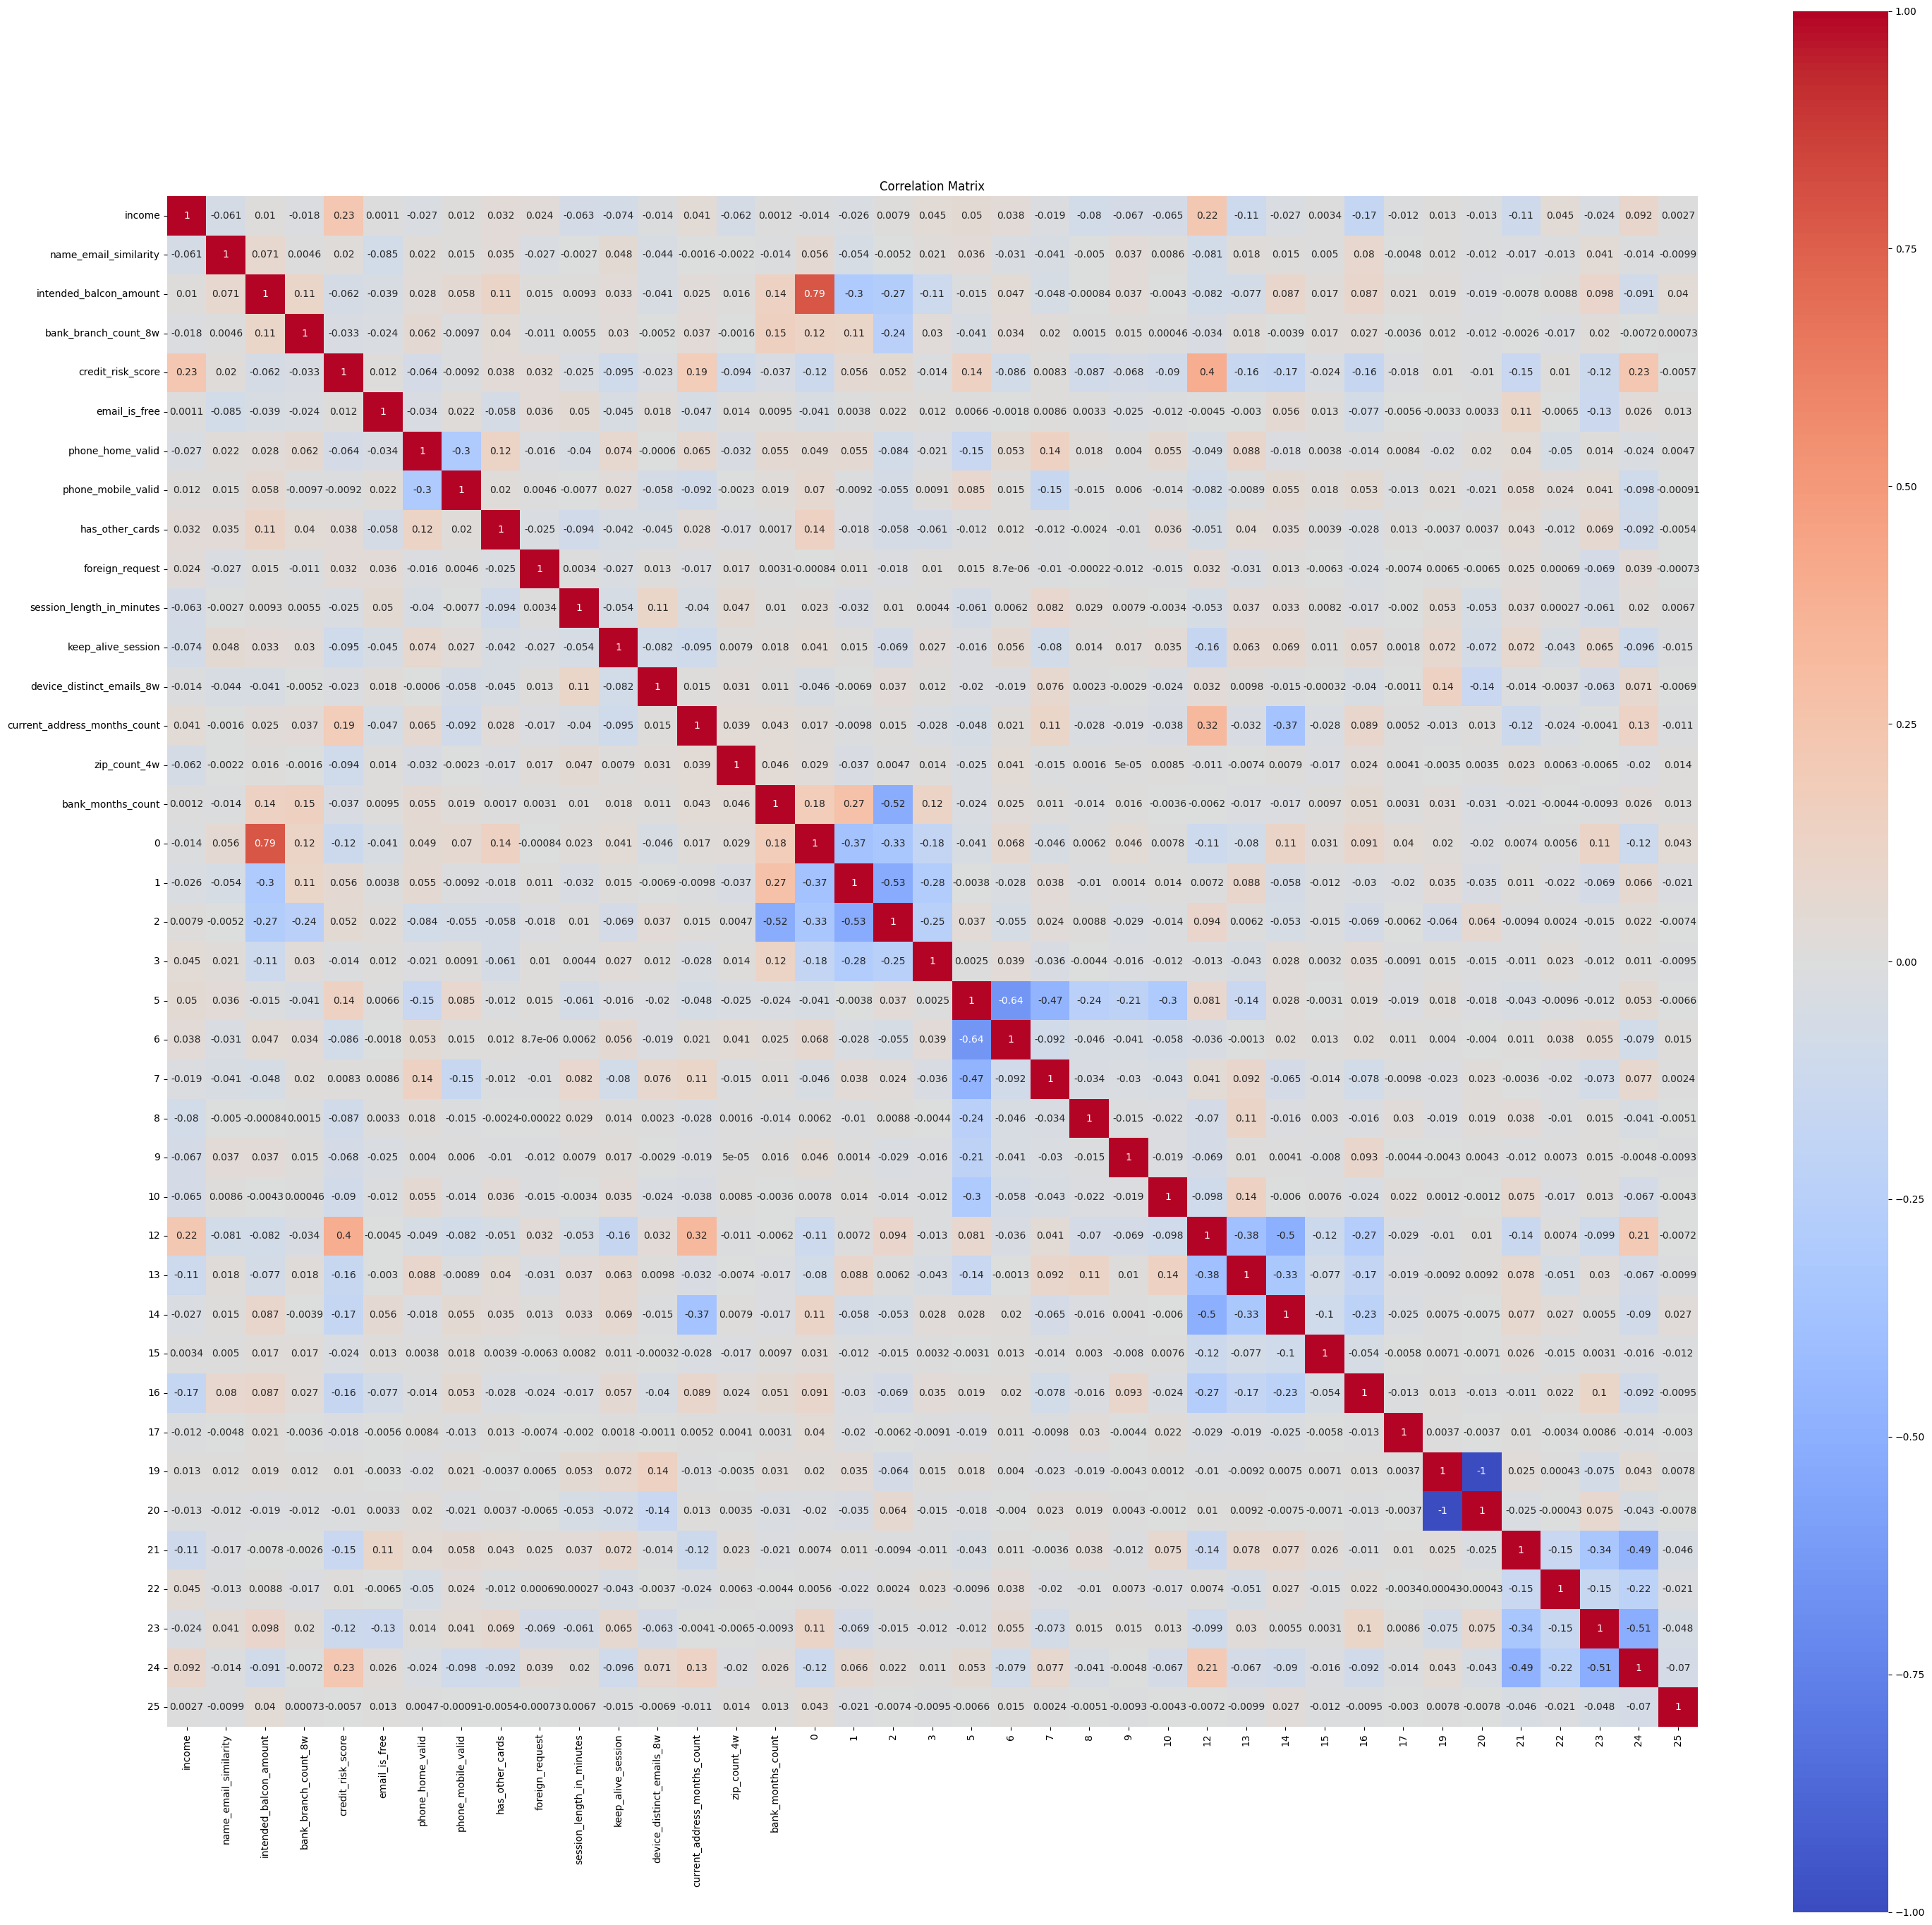

In [34]:
corr_matrix = x_resam.corr()

# Create a heatmap to visualize the correlation matrix

plt.figure(figsize=(35, 35))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Matrix')

plt.show()

In [35]:
corr_li =[]
thresh =  0.6
for i in corr_matrix:
    for j in corr_matrix:
        val = abs(corr_matrix[i][j])
        #print(val)
        if val > thresh and val != 1:
            #print(val)
            corr_li.append(i)        

In [36]:
corr_li = list(set(corr_li))

In [37]:
corr_li

['0', '5', '6', 'intended_balcon_amount']

In [38]:
c = x_resam.columns

In [39]:
fi = []

for i in c:
    if i not in corr_li:
        fi.append(i)

In [40]:
x_resam = x_resam[fi]

x_test = x_test[fi]

In [41]:
lr.fit(x_resam,y_resam)
THRESHOLD = 0.9
lr_pred = np.where(lr.predict_proba(x_test)[:,1] > THRESHOLD, 1, 0)
lr_pred_t = np.where(lr.predict_proba(x_resam)[:,1] > THRESHOLD, 1, 0)
#lr_pred = lr.predict(x_test)
print(f1_score(y_test,lr_pred))

0.19605462822458272


In [42]:
rfn.fit(x_resam,y_resam)
rfn_pred = rfn.predict(x_test)
rfn_pred_t = rfn.predict(x_resam)
print(f1_score(y_test,rfn_pred))

0.06848041395480453


In [43]:
gnb.fit(x_resam,y_resam)
gnb_pred = gnb.predict(x_test)
gnb_pred_t = gnb.predict(x_resam)
print(f1_score(y_test,gnb_pred))

0.05663000120875135


In [44]:
bg.fit(x_resam,y_resam)
bg_pred = bg.predict(x_test)
bg_pred_t = bg.predict(x_resam)
print(f1_score(y_test,bg_pred))

0.08169618641069785


In [45]:
vc.fit(x_resam,y_resam)
vc_pred = vc.predict(x_test)
vc_pred_t = vc.predict(x_resam)
print(f1_score(y_test,vc_pred))

0.08104695212949145


# Logistic Regresssion gives the best results, so we are going to use stacking and logistic regression together

In [46]:
stack = pd.DataFrame(lr_pred_t,columns=['lr'])
stack['rf'] = rfn_pred_t
stack['gn']  = gnb_pred_t
stack['vc'] = vc_pred_t
stack['bg'] = bg_pred_t

In [47]:
stack_test = pd.DataFrame(lr_pred,columns=['lr'])
stack_test['rf'] = rfn_pred
stack_test['gn']  = gnb_pred
stack_test['vc'] = vc_pred
stack_test['bg'] = bg_pred

# Checking final result

In [48]:
lr.fit(stack,y_resam)
THRESHOLD = 0.9
stacked_lr_pred = np.where(lr.predict_proba(stack_test)[:,1] > THRESHOLD, 1, 0)
print(f1_score(y_test,stacked_lr_pred))

0.19589209074187613


# Applying Grid Search CV for finding best parameters

In [49]:
lrf = LogisticRegression()
parameters = { 'penalty' : ('l1', 'l2', 'elasticnet'), 
              'C' : [0.1, 0.2, 0.4, 0.6, 0.8, 1.0], 
              'class_weight' : ('balanced', None), 
              'random_state' : [ 0,10,30,60,90] , 
              'solver' : ('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'),
              'max_iter' : [ 1000 ] }
                          
clf = GridSearchCV(lrf, parameters)

In [50]:
clf.fit(stack,y_resam)
THRESHOLD = 0.9
stacked_lr_pred = np.where(clf.predict_proba(stack_test)[:,1] > THRESHOLD, 1, 0)
print(f1_score(y_test,stacked_lr_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3000 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

0.19589209074187613


# Best parameters

In [51]:
clf.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 1000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

In [52]:
lrf = LogisticRegression(C= 0.4,
 class_weight = 'balanced',
 max_iter = 1000,
 penalty =  'l2',
 random_state = 0,
 solver = 'liblinear')

In [53]:
lrf.fit(stack,y_resam)
THRESHOLD = 0.9
stacked_lr_pred = np.where(lrf.predict_proba(stack_test)[:,1] > THRESHOLD, 1, 0)
print(f1_score(y_test,stacked_lr_pred))

0.19589209074187613


# Creating test DataFrame for final result

In [54]:
test_result = pd.DataFrame(x_test)
test_result['Y_test'] = y_test
test_result['log'] = lr_pred
test_result['RFC'] = rfn_pred
test_result['GN'] = gnb_pred
test_result['VC'] = vc_pred
test_result['BG'] = bg_pred
test_result['final'] = stacked_lr_pred


In [55]:
output_file = 'assignment2.csv'
test_result.to_csv(output_file,index=True)